# CatBoost Regressor for Web3 Wallet Credit Scores

This notebook demonstrates how to perform hyperparameter tuning on a CatBoost Regressor using RandomizedSearchCV, evaluate the model, analyze feature importance, and save the tuned model for future use.

In [7]:
# --- Import Libraries ---
import pandas as pd
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that plots appear inline in the notebook
%matplotlib inline

## Step 1: Load and Prepare Data

In this step, we load the data from `macro_credit_scores.csv`, drop any unused columns, define the features and target, and split the data into training and testing sets.

In [8]:
# --- Step 1: Load and Prepare Data ---
df = pd.read_csv('dataset/macro_credit_scores.csv')

# Drop Unused Columns if they exist
df = df.drop(columns=['Cluster', 'FICO Range'], errors='ignore')

# Define features and target
X = df.drop(columns=['Credit Score'])  # Features
y = df['Credit Score']  # Target

# Save feature names in correct order for later reference
feature_names = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

## Step 2: Define Hyperparameter Grid

Define the hyperparameter grid for the CatBoost Regressor. The grid uses a combination of discrete and continuous distributions for parameters like `iterations`, `learning_rate`, `depth`, etc. These will be sampled during the randomized search.

In [9]:
# --- Step 2: Define Hyperparameter Grid ---
param_grid = {
    'iterations': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10),
    'border_count': randint(32, 100),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(0, 1)
}

## Step 3: Hyperparameter Tuning with RandomizedSearchCV

Initialize a CatBoost Regressor with some basic settings. Then, set up RandomizedSearchCV with 5-fold cross-validation to search for the best combination of hyperparameters. The best parameters and model are then obtained.

In [10]:
# --- Step 3: Initialize and Run RandomizedSearchCV ---
print("\n--- Hyperparameter Tuning with RandomizedSearchCV ---")

# Initialize CatBoost Regressor with specified loss and silent logging
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='R2',
    random_seed=42,
    logging_level='Silent'  # Disable verbose output
)

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of different combinations to try
    scoring='r2',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Utilize all available processors
    error_score='raise'
)

# Fit RandomizedSearchCV with the training data
random_search.fit(X_train, y_train)

# Display the best hyperparameters found
print("\n[INFO] Best Hyperparameters:", random_search.best_params_)

# Obtain the best model from the randomized search
best_catboost_model = random_search.best_estimator_


--- Hyperparameter Tuning with RandomizedSearchCV ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

[INFO] Best Hyperparameters: {'bagging_temperature': np.float64(0.965255307264138), 'border_count': 91, 'depth': 7, 'iterations': 992, 'l2_leaf_reg': np.float64(2.4092422497476265), 'learning_rate': np.float64(0.17043939615080794), 'random_strength': np.float64(0.07455064367977082)}


## Step 4: Model Training and Evaluation

Train the best CatBoost model on the training data. Then, predict on the test set and evaluate the model using R2 Score and Mean Squared Error (MSE).

In [11]:
# --- Step 4: Model Training and Evaluation ---
print("\n--- Training Best CatBoost Model ---")
best_catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_catboost_model.predict(X_test)

# Evaluate the model
print("\n--- Model Evaluation ---")
print("CatBoost - R2 Score:", r2_score(y_test, y_pred))
print("CatBoost - MSE:", mean_squared_error(y_test, y_pred))


--- Training Best CatBoost Model ---

--- Model Evaluation ---
CatBoost - R2 Score: 0.9813901064672125
CatBoost - MSE: 0.0012891334385461578


## Step 5: Feature Importance Analysis

Extract and visualize the feature importances from the tuned CatBoost model. This analysis helps identify which features contribute the most to the predictions.


--- Feature Importance Analysis ---


C:\Users\user\AppData\Local\Temp\ipykernel_26208\1068233563.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


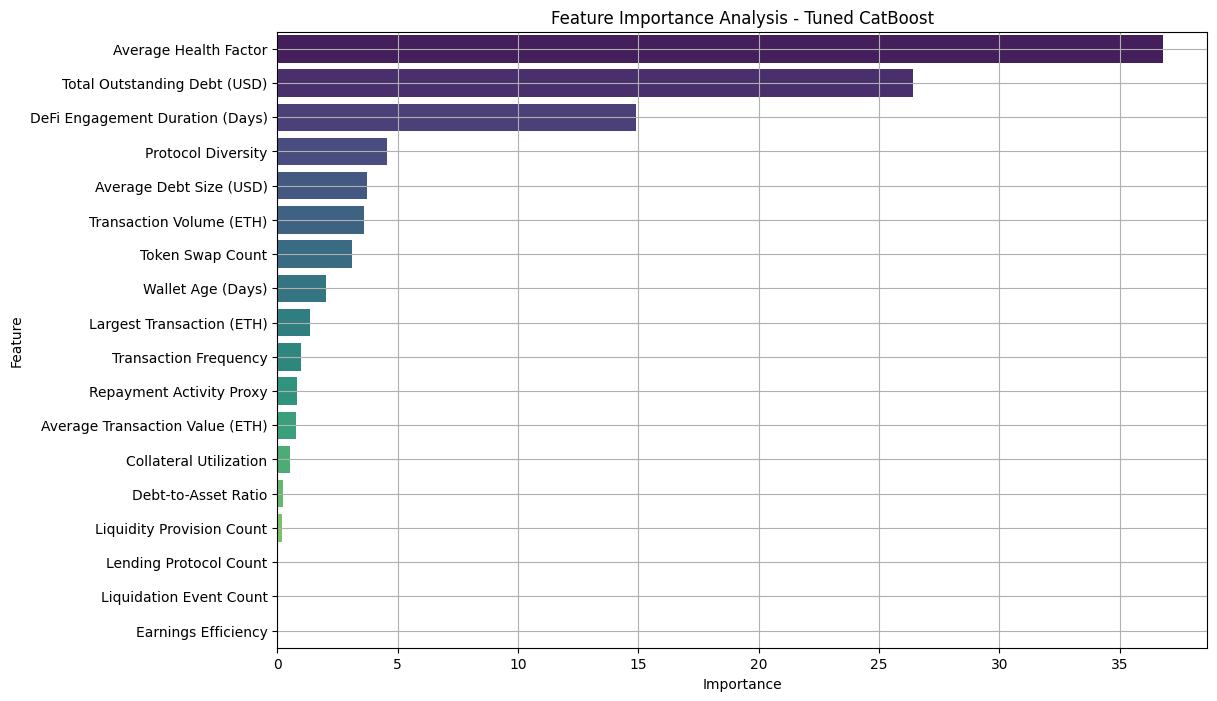

In [12]:
# --- Step 5: Feature Importance Analysis ---
print("\n--- Feature Importance Analysis ---")
feature_importance = best_catboost_model.feature_importances_

# Create a DataFrame for the feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Analysis - Tuned CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

## Step 6: Save Best Model

Finally, save the tuned CatBoost model to disk using `joblib` so that it can be reused later without needing to re-run the tuning or training steps.

In [13]:
# --- Step 6: Save Best Model ---
if not os.path.exists("models"):
    os.makedirs("models")
    
joblib.dump(best_catboost_model, 'models/catboost_credit_score_model.pkl')
print("[INFO] CatBoost Model saved as 'catboost_credit_score_model.pkl'")

[INFO] CatBoost Model saved as 'catboost_credit_score_model.pkl'
